In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
import jax.numpy as jnp
import jax
import jax.random as jr
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

is_dark = False
theme, cs = rp.mpl_setup(is_dark)
rp.plotly_setup(is_dark)

In [2]:
%cd ~/cdv/

/home/nmiklaucic/cdv


/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [8]:
from pathlib import Path
import pyrallis
from cdv.config import MainConfig
import orbax.checkpoint as ocp

from cdv.training_state import TrainingRun
from cdv.checkpointing import best_ckpt

# run_dir = Path('logs') / '06-30-19_406'
run_dir = Path('logs') / 'refactor_102'

with open(run_dir / 'config.toml') as conf_file:
    config = pyrallis.cfgparsing.load(MainConfig, conf_file)

if config.task == 'e_form':
    model = config.build_regressor()
elif config.task == 'vae':
    model = config.build_vae()


ckpt = best_ckpt(run_dir)
ckpt = jax.tree.map(lambda x: x if isinstance(x, (float, int)) else x.astype(jnp.float32), ckpt)
# model = model.bind(ckpt['state']['params'])

Configured `CheckpointManager` using deprecated legacy API. Please follow the instructions at                      
https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate by May 1st, 2024.

Given directory is read only=/home/nmiklaucic/cdv/logs/refactor_102/final_ckpt/ckpts

Restoring item from /home/nmiklaucic/cdv/logs/refactor_102/final_ckpt/ckpts/22499.

Finished restoring checkpoint from /home/nmiklaucic/cdv/logs/refactor_102/final_ckpt/ckpts/22499.

In [4]:
from cdv.dataset import load_file, stack_trees
cg = load_file(config)
cg

CrystalGraphs(nodes=(1024, 3), edges=(1024, 16), graphs=(32,))

In [12]:
from cdv.layers import Context
from cdv.regression import EFSWrapper
ctx = Context(training=False)

out = EFSWrapper()(model.apply, ckpt['state']['params'], cg=cg, ctx=ctx)
out


EFSOutput(
    energy=Array([[ -8.097197  ],
       [ -7.2521195 ],
       [ -6.3271155 ],
       [ -4.490765  ],
       [ -5.1013527 ],
       [ -9.451162  ],
       [ -5.870725  ],
       [ -8.137844  ],
       [ -5.657994  ],
       [ -5.772934  ],
       [ -4.585565  ],
       [ -8.476302  ],
       [ -6.949283  ],
       [ -7.6523585 ],
       [ -5.307356  ],
       [ -7.5254655 ],
       [ -6.6701837 ],
       [ -7.5140176 ],
       [ -6.6827493 ],
       [ -5.581137  ],
       [ -9.602773  ],
       [ -4.0304275 ],
       [ -8.732369  ],
       [ -5.511499  ],
       [ -7.325319  ],
       [ -3.9198284 ],
       [ -7.4241867 ],
       [ -7.214806  ],
       [-10.03207   ],
       [ -5.9288793 ],
       [ -7.0438657 ],
       [  0.10571503]], dtype=float32),
    force=Array([[ 0.09518433, -0.12104034,  0.06345558],
       [ 0.0873642 ,  0.14580727, -0.06214285],
       [-0.0873642 , -0.14580727, -0.06214285],
       ...,
       [-0.        , -0.        , -0.        ],
       [-0

In [85]:
jnp.linalg.det(cg.graph_data.lat)


Array([2696.727   ,  992.36285 ,  620.93396 ,  776.3881  , 1254.885   ,
        445.16635 ,  662.7077  ,  448.4857  ,  603.1233  ,  495.03308 ,
        755.0803  ,  326.15817 ,  325.39355 ,  279.91446 ,  277.42963 ,
        258.77118 ,  274.63596 ,  342.94644 ,  159.77986 ,  166.9987  ,
        158.49847 ,  213.66805 ,  142.81676 ,  195.74626 ,  103.411896,
        204.39546 ,   65.49931 ,   44.829044,   61.68288 ,   52.1802  ,
         26.543814,    0.      ], dtype=float32)

In [ ]:
loss = config.train.loss.efs_loss(cg, out)

In [35]:
cg.nodes.graph_i[:272]


Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [93]:
from pymatgen.core import Lattice

lat = Lattice(cg.graph_data.lat[0])

In [97]:
volume = jnp.abs(jnp.linalg.det(cg.graph_data.lat))[..., None, None]
stress_cell = (0.1 * out.stress / jnp.where(volume == 0, jnp.ones_like(volume), volume))

15.490802


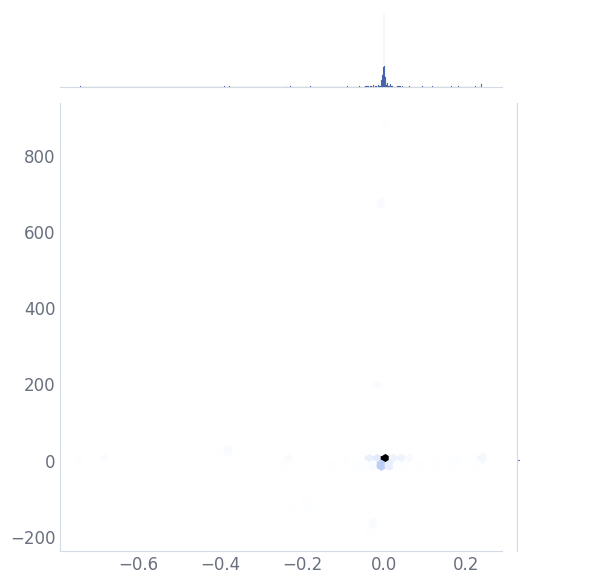

In [98]:
y = cg.target_data.stress[cg.padding_mask]
volume = jnp.linalg.det(cg.graph_data.lat)[..., None, None]
yhat = stress_cell[cg.padding_mask]

z = y - yhat
# z = z[cg.padding_mask[cg.nodes.graph_i]]
print(jnp.mean(jnp.abs(z)))
sns.jointplot(x=yhat.reshape(-1), y=y.reshape(-1), kind='hex')

In [40]:
cg.graph_data.lat[1]


Array([[10.297847  ,  0.        , -2.931051  ],
       [ 0.        ,  9.247357  ,  0.        ],
       [-0.02958372,  0.        , 10.42935   ]], dtype=float32)

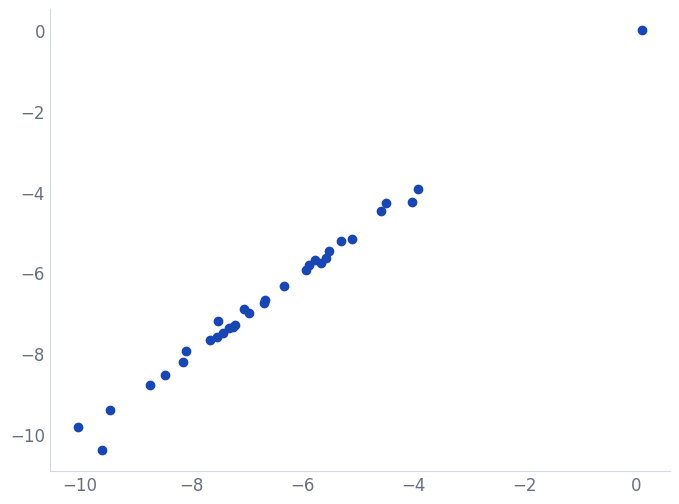

In [13]:
plt.scatter(out.energy, cg.e_form)